In [1]:
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.anuga import SWW_plotter
import numpy as np
import pandas as pd
%matplotlib inline
import geopandas as gpd
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from cresthh import metrics as met
from netCDF4 import Dataset
from glob import glob
from osgeo import gdal
from pyproj import Proj, CRS, transform

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

# 1D streamflow

In [8]:
OUTLET=(284219.573,3302832.615)
crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/08076700.shp')

In [10]:
benchmark= processSWW('Coupled_10m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
# coupled_30m= processSWW('Coupled_30m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
noncoupled_10m= processSWW('nonCoupled_10m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
# coupled_noConstraint=processSWW('nonCoupled_10m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
coupled_FAM= processSWW('Coupled_10m_flow_acc_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot


In [11]:
benchmark['area']= benchmark.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
noncoupled_10m['area']= noncoupled_10m.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
# coupled_30m['area']= coupled_30m.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
coupled_FAM['area']= coupled_FAM.apply(lambda x: flow_area(crosssection, x.stage+2.859193), axis=1)
# coupled_noConstraint['area']= coupled_noConstraint.apply(lambda x: flow_area(crosssection, x.stage), axis=1)

In [12]:
benchmark['Q']= benchmark.speed * benchmark.area
noncoupled_10m['Q']= noncoupled_10m.speed * noncoupled_10m.area
# coupled_30m['Q']= coupled_30m.speed * coupled_30m.area
coupled_FAM['Q']= coupled_FAM.speed * coupled_FAM.area
# coupled_noConstraint['Q']= coupled_noConstraint.speed * coupled_noConstraint.area

In [37]:
coupled_FAM.stage+=2.859193

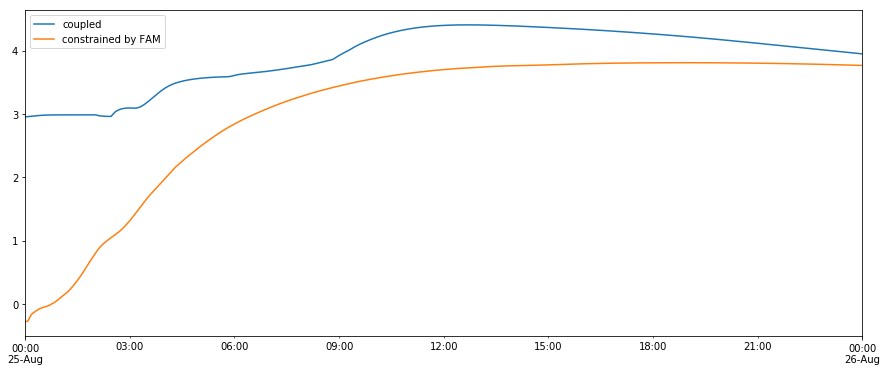

In [12]:
plt.figure(figsize=(15,6))
benchmark.stage.plot(label='coupled')
noncoupled_10m.stage.plot(label='non-coupled')
# coupled_30m.stage.plot(label='coupled-30m DEM')
coupled_FAM.stage.plot(label='constrained by FAM')
# coupled_noConstraint.stage.plot(label='no constraint')
plt.legend();

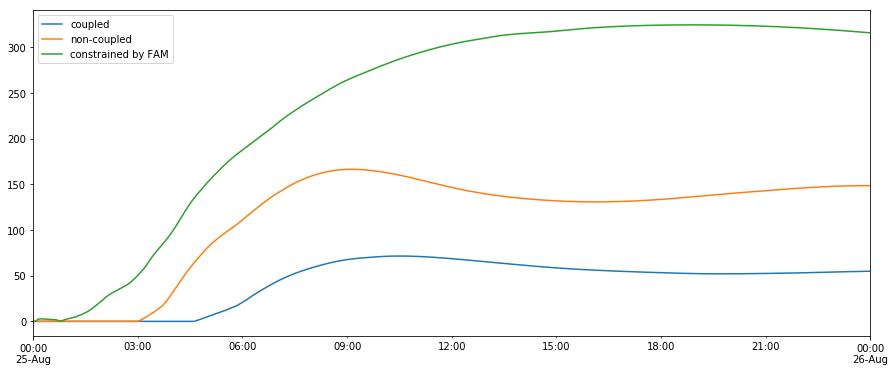

In [13]:
plt.figure(figsize=(15,6))
benchmark.Q.plot(label='coupled')
noncoupled_10m.Q.plot(label='non-coupled')
# coupled_30m.Q.plot(label='coupled-30m DEM')
coupled_FAM.Q.plot(label='constrained by FAM')
# coupled_noConstraint.Q.plot(label='no constraint')
plt.legend();

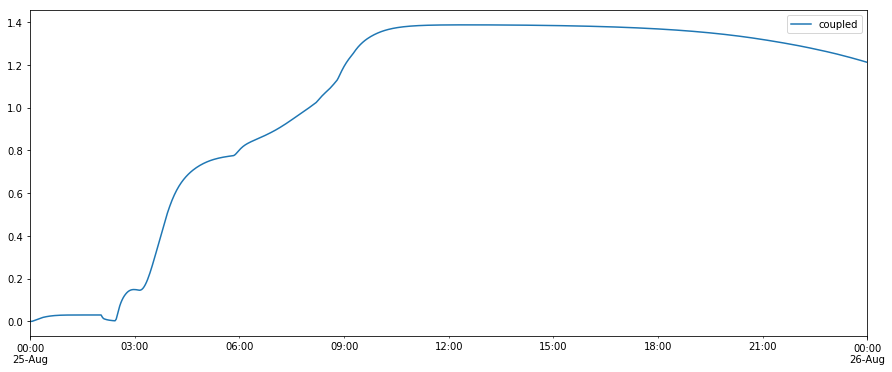

In [8]:
plt.figure(figsize=(15,6))
benchmark.speed.plot(label='coupled')
# noncoupled_10m.speed.plot(label='non-coupled')
# coupled_30m.speed.plot(label='coupled-30m DEM')
# coupled_FAM.speed.plot(label='constrained by FAM')
# coupled_noConstraint.speed.plot(label='no constraint')
plt.legend();